In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_dir = "/content/drive/MyDrive/DS340_Final_Project/augmented_spectrograms_dataset_speech"

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Image dimensions
IMG_HEIGHT, IMG_WIDTH = 128, 128
BATCH_SIZE = 16

# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle = False
)

Found 4613 images belonging to 8 classes.
Found 1147 images belonging to 8 classes.


In [4]:
from tensorflow.keras import layers, regularizers, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
input_shape = (128, 128, 3)

In [5]:
speech_model = Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(1e-4)), # add l2 regularization
        # remove max pooling
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(1e-4)), #add l2 regularization
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(1e-4)), #add l2 regularization
        # remove max pooling
        layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(1e-4)), #add l2 regularization
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
        layers.Dropout(0.5),
        layers.Dense(8, activation='softmax'),
    ]
)

In [6]:
speech_model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=["accuracy"]) # modify learning rate

import keras.callbacks
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)  # Quit after 3 rounds of no validation loss improvement
]

history = speech_model.fit(train_generator, epochs=15, validation_data=val_generator, callbacks=callbacks)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 3945s 14s/step - accuracy: 0.2405 - loss: 2.3745 - val_accuracy: 0.4167 - val_loss: 1.8607
Epoch 2/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.4675 - loss: 1.6970 - val_accuracy: 0.4987 - val_loss: 1.6810
Epoch 3/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.5798 - loss: 1.4065 - val_accuracy: 0.5083 - val_loss: 1.6995
Epoch 4/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.6763 - loss: 1.2297 - val_accuracy: 0.5501 - val_loss: 1.6101
Epoch 5/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.7391 - loss: 1.1049 - val_accuracy: 0.5728 - val_loss: 1.6009
Epoch 6/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.7843 - loss: 0.9468 - val_accuracy: 0.5833 - val_loss: 1.5488
Epoch 7/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.8268 - loss: 0.8596 - val_accuracy: 0.5850 - val_loss: 1.6482
Epoch 8/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.8354 - loss: 0.8136 -

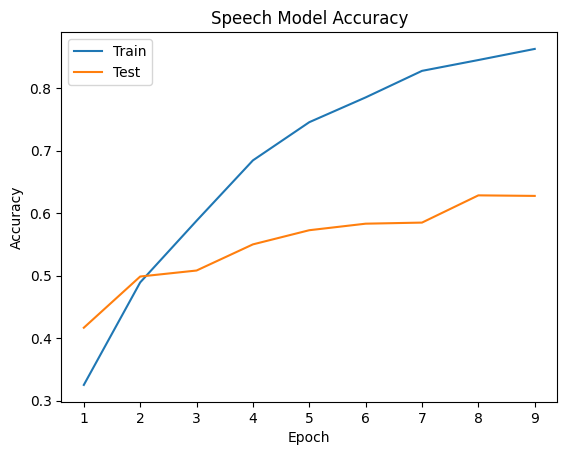

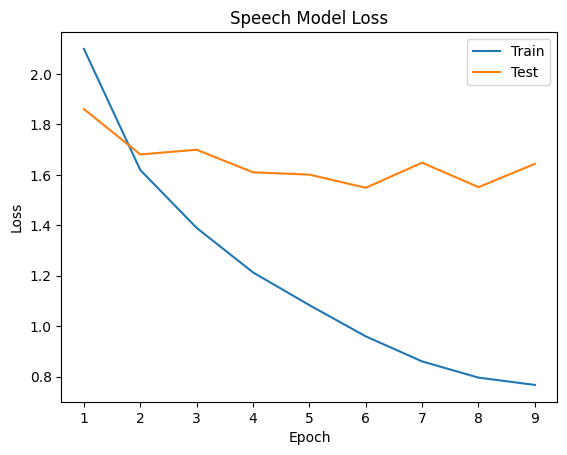

In [13]:
import matplotlib.pyplot as plt

# Retrieve metrics from the history object
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(1, len(acc) + 1)

# Plot training & validation accuracy
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Speech Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

# Plot training & validation loss
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Speech Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

In [9]:
import numpy as np
from sklearn.metrics import classification_report, f1_score

y_pred_probs = speech_model.predict(val_generator)
y_pred       = np.argmax(y_pred_probs, axis=1)
y_true       = val_generator.classes

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step


In [10]:
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Weighted F1 score: {f1:.4f}")

Weighted F1 score: 0.6312


In [11]:
import numpy as np
from sklearn.metrics import classification_report


class_indices = val_generator.class_indices

idx2class = {idx: cls for cls, idx in class_indices.items()}
all_labels = sorted(idx2class.keys())
all_names  = [idx2class[idx] for idx in all_labels]


print(classification_report(
    y_true,
    y_pred,
    labels=all_labels,
    target_names=all_names,
    zero_division=0
))


              precision    recall  f1-score   support

       angry       1.00      0.52      0.68       153
        calm       0.66      0.75      0.71       153
     disgust       0.66      0.78      0.72       153
     fearful       0.88      0.49      0.63       153
       happy       0.70      0.48      0.57       153
     neutral       0.56      0.74      0.64        76
         sad       0.41      0.61      0.49       153
   surprised       0.54      0.71      0.61       153

    accuracy                           0.63      1147
   macro avg       0.68      0.63      0.63      1147
weighted avg       0.69      0.63      0.63      1147



In [12]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

IMG_PATH = "/content/drive/MyDrive/DS340_Final_Project/Lecture_recording.png"
img = load_img(IMG_PATH, target_size=(128, 128))
x   = img_to_array(img) / 255.0
x   = np.expand_dims(x, axis=0)

probs = speech_model.predict(x)
pred_idx = int(np.argmax(probs))

idx2label = {v: k for k, v in train_generator.class_indices.items()}

pred_label = idx2label[pred_idx]
print(f"Predicted emotion: {pred_label}  (p = {probs[0][pred_idx]:.3f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
Predicted emotion: calm  (p = 0.950)
